# Data Reclassification

Input Data

We will use Travel Time Matrix data from Helsinki that contains travel time and distance information for routes between all 250 m x 250 m grid cell centroids (n = 13231) in the Capital Region of Helsinki by walking, cycling, public transportation and car.

- In this tutorial, we will use the geojson file generated in the previous section: "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

- Alternatively, you can re-download L4 data and use "data/Travel_times_to_5975375_RailwayStation.shp" as input file in here.

- First, we need to read our Travel Time data from Helsinki:

In [1]:
import geopandas as gpd

fp = "TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

#Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

#lets see what we have
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402003.328 6685762.545, 402143.720 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403243.781 6685772.634, 403250.000 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((402000.000 6685592.186, 402000.000 6..."


interested in are columns:
- pt_r_tt which is telling the time in minutes that it takes to reach city center from different parts of the city
- walk_d that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

The NoData values are presented with value -1.

- Thus we need to remove the No Data values first.

In [2]:
# Include only data that is above or equal to 0
acc = acc.loc[acc['pt_r_tt'] >= 0 ]

#acc['pt_r_tt'] >=0 mask to look for all row indices in pt_r_tt column that meet the condition, extract all those rows from the df.

Let’s plot the data and see how it looks like

- cmap parameter defines the color map. Read more about choosing colormaps in matplotlib

- scheme option scales the colors according to a classification scheme (requires mapclassify module to be installed):

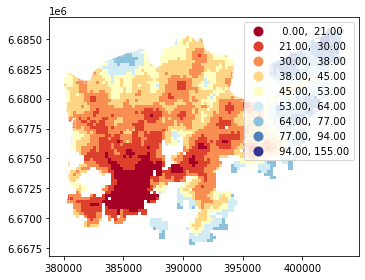

In [3]:
import matplotlib.pyplot as plt

#plot using 9 classes and classify the values or "pt_r_tt" using "Natural Breaks" classification
acc.plot(column= "pt_r_tt", scheme= "Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend =True)

#use tight layout
plt.tight_layout() #use to remove the surrounding white spaces of the plot

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of “good” accessibility also in some other areas 
(where the color is red).

Let’s also make a plot about walking distances:

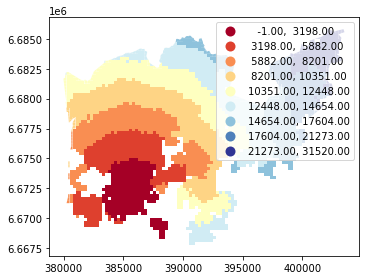

In [4]:
#plot walking distance using 9 classes and classify walk_d.
acc.plot(column="walk_d", scheme="Natural_Breaks",k=9,cmap="RdYlBu", linewidth= 0, legend=True)

#use tight layout
plt.tight_layout()

Okay, from here we can see that the walking distances (along road network) reminds more or less Euclidian distances.

Applying classifiers to data

- scheme option defines the classification scheme using pysal/mapclassify

In [5]:
import mapclassify

- Natural Breaks

In [6]:
mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  21.00] |   263
( 21.00,  30.00] |   529
( 30.00,  38.00] |   873
( 38.00,  44.00] |   727
( 44.00,  54.00] |   605
( 54.00,  68.00] |   459
( 68.00,  85.00] |   210
( 85.00, 115.00] |   138
(115.00, 155.00] |     3

- Quantiles (default s 5 classes)

In [7]:
mapclassify.Quantiles(y=acc['pt_r_tt'])

Quantiles               

    Interval       Count
------------------------
[  0.00,  30.00] |   792
( 30.00,  37.00] |   779
( 37.00,  44.00] |   821
( 44.00,  56.00] |   685
( 56.00, 155.00] |   730

In [8]:
#extract the threshold values into an array
classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)
classifier.bins

array([ 19.,  29.,  37.,  45.,  54.,  65.,  79.,  96., 155.])

- Let’s apply one of the Pysal classifiers into our data and classify the travel times by public transport into 9 classes

- The classifier needs to be initialized first with make() function that takes the number of desired classes as input parameter

In [9]:
#Create a natural breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

- now we can apply that classifier into our data by using apply function

In [10]:
#apply Classifier the pt_r_tt column 
classifications = acc[['pt_r_tt']].apply(classifier)

#Lets see what we have
classifications.head()

,pt_r_tt
0,8
1,7
2,8
3,8
4,8


In [11]:
type(classifications)

pandas.core.frame.DataFrame

The result for the classification of column 'pt_r_tt' is a new column where each row is classified into 9 different classes (number 1-9) based on natural breaks classification

- add the classification values directly into a new column in our dataframe

In [12]:
#create new column nb_pt_r_tt to store the classified values of pt_r_tt using natural breaks.
acc['nb_pt_r_tt'] = acc[['pt_r_tt']].apply(classifier)

#extract the top 5 rows for original values and classification columns
acc[['pt_r_tt', 'nb_pt_r_tt']].head()

,pt_r_tt,nb_pt_r_tt
0,99,8
1,93,7
2,146,8
3,155,8
4,99,8


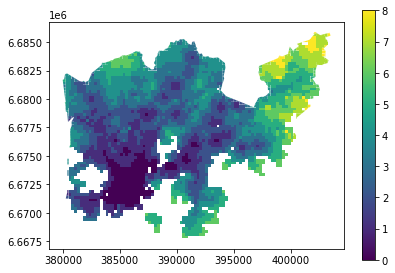

In [13]:
#visualize the classification scheme
acc.plot( column='nb_pt_r_tt', linewidth=0,legend=True)

#use tight layout
plt.tight_layout()

now we have a map where we have used one of the common classifiers to classify our data into 9 classes.

Classification explanation: Natural Break, Standard Deviation, Equal Interval
http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Classification

Plotting a histogram

- histogram is a graphic representation of the distribution of the data. 
- When classifying the data, it’s always good to consider how the data is distributed, and how the classification shceme divides values into different ranges.

plot histogram using pandas.DataFrame.plot.hist

Number of histogram bins(groups of data) can be controlled using the parameter bins:

<AxesSubplot:ylabel='Frequency'>

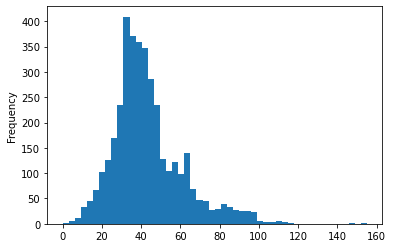

In [14]:
#create a histogram for column 'pt_r_tt' with 50 bins
acc['pt_r_tt'].plot.hist(bins=50)

Add threshold values on top of the histogram vertical lines
- Natural Breaks

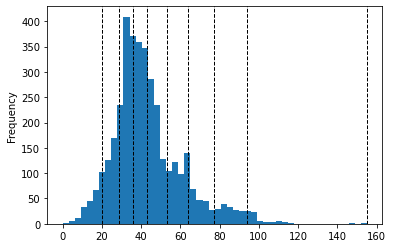

In [15]:
#define natural breaks classifier with 9 bins
classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

#plot the histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

#add vertical lines for class breaks using the classifier bins
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)

- Quantiles

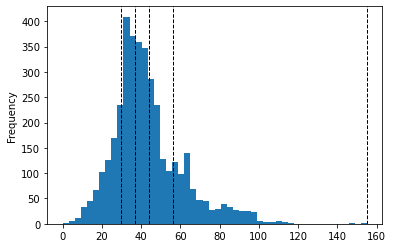

In [16]:
#define quantiles classifier 
classifier = mapclassify.Quantiles(y=acc['pt_r_tt'])

#plot the histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

#plot each quantile bin on the map.
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)

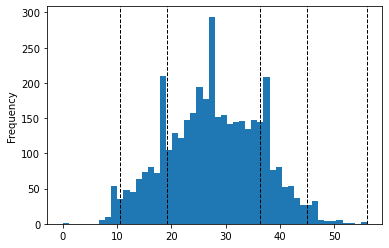

In [17]:
#create a stdmean classifier
classifier = mapclassify.StdMean(y= acc['car_r_t'])

acc['car_r_t'].plot.hist(bins=50)

for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed',linewidth=1)

<AxesSubplot:>

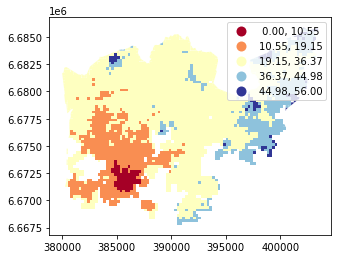

In [18]:
#plot using 9 classes and classify the values or "pt_r_tt" using "Natural Breaks" classification
acc.plot(column= "car_r_t", scheme= "StdMean", k=9, cmap="RdYlBu", linewidth=0, legend =True)

The standard deviation for travel time by car in the city center is the lowest from the average car travel time of the entire state

The standard deviation for travel time by car in the suburban areas is the highest relative to average car travel time of the entire state.


In [19]:
print("Mean Car Travel Time: ", acc["car_r_t"].mean())

print("Classifier Bins: ", classifier.bins)

Mean Car Travel Time:  27.761754662463883
Classifier Bins:  [10.54516856 19.15346161 36.37004771 44.97834077 56.        ]


# Creating Custom Classifier

- create a function where we classify the geometries into two classes based on a given threshold -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a binary classification.

In [21]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    """Custom classifier that can be applied on each row of a pandas dtaframe (axis=1).
    
    This function classifies data based on values in two source columns and stores the output value in the output column.
    Output values is 1 if the value in src_col1 is LOWER than the threshold1 value AND the value in srr_col2 is higher than threshold2 value.
    In all other cases, output value is 0.
    
    ARGS:
        row: one row of data
        src_col1: source column named associated with threshold 1
        src_col2: source column named associated with threshold 2
        threshold1: upper threshold value for src_col1
        threshold2: lower threshold value for src_col2
        output_col: output column name
        
    Returns:
        updated row of data.
    """
    
    #if condition is true, assign 1 into output column
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        row[output_col] = 1
        
    #else, assign 0 into output column
    else:
        row[output_col] = 0
    
    #return the updated row
    return row

Classification based on 2 criteria, find out grid cells:
- travel time is lower or equal to 20 minutes
- and travel distance are further away than 4km (4000 meters) from city center.

append results to empty column for our classification results called "suitable_area"

In [22]:
#Create column for the classification results
acc["suitable_area"] = None

#apply function to acc dataframe
acc = acc.apply(custom_classifier,
                src_col1 = 'pt_r_tt',
                src_col2 = 'walk_d',
                threshold1 = 20,
                threshold2 = 4000,
                output_col = 'suitable_area',
                axis=1)

#see the first rows
acc.head()
                

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry,nb_pt_r_tt,suitable_area
0,29476,41,29483,46,5876274,29990,76,95,24984,77,...,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402003.328 6685762.545, 402143.720 6...",8,0
1,29456,41,29462,46,5876275,29866,74,95,24860,75,...,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6...",7,0
2,36772,50,36778,56,5876278,33541,116,137,44265,130,...,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403243.781 6685772.634, 403250.000 6...",8,0
3,36898,49,36904,56,5876279,33720,119,141,44444,132,...,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6...",8,0
4,29411,40,29418,44,5878128,29944,75,95,24938,76,...,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((402000.000 6685592.186, 402000.000 6...",8,0


In the suitable areas column, how many polygons meet the requirement of having a travel time < 20 mins and travel distance > 4km ? 
- Use dataFrame.value_counts() to show the distribution of counts for our column

In [24]:
#Get value counts to check distribution of suitable areas
acc['suitable_area'].value_counts()

0    3798
1       9
Name: suitable_area, dtype: int64

There are 9 suitable areas where can try to find an appartment to buy

Plot there location on the map

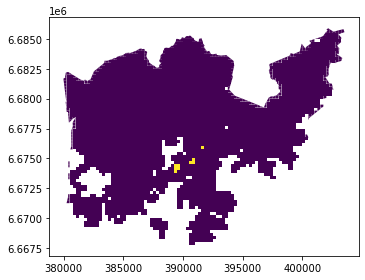

In [25]:
acc.plot(column="suitable_area", linewidth=0)

#remove surrounding whitespace on the map
plt.tight_layout()

Visualizing the suitable places with our criteria, the locations appears to be on the eastern part from the city center. Locations
are along the metro line which makes them good locations in terms of travel time to city center since metro is really fast travel mode.